First, we import the libraries, and load the trained model and the data (with readuced features).

In [1]:
import os
import h5py
import tempfile
import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model, save_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from functions import plot_regression

In [2]:
project_dir='/your/directory'
data_dir=os.path.join(project_dir,'data')
model_dir=os.path.join(project_dir,'results_reduced_features')
results_dir=os.path.join(project_dir,'results_pruning')
string_dir='mkdir -p '+results_dir
os.system(string_dir)

0

For this process, we will use only one model, and one rep for testing. We have chosen the model that yielded the best metrics.

In [3]:
rep_to_test=2 # Rep to use for testing the model

X=[]
Y=[]
for rep in range(1,4):
    if rep != rep_to_test:
        #Data
        file_name_data=os.path.join(data_dir,'rep_'+str(rep),'data_train.h5')
        h5f=h5py.File(file_name_data,'r')
        x=h5f['train_dataset'][:]
        h5f.close()
        X.append(x)

        #Labels
        y=[]
        file_name_labels=os.path.join(data_dir,'rep_'+str(rep),'labels_train.txt')
        file = open(file_name_labels,"r") 
        for line in file:
            y.append(float(line.strip()))
        Y.append(y)
        
# Feature selection
# We begin with spectral bands
X_rb=[]
for i in range(2):
    X_rb.append(X[i][:,:,:,:,2:4]) # channels 2 and 3 correspond to red and red edge

# We can now deal with the dates
X_rd=[]
for i in range(2):
    X_rd.append(X_rb[i][:,[4,6,10,11],:,:,:]) # dates 5, 7, 11, 12 correspond to indexes 4,6,10,11
    
# Generate the datasets 
X_train=np.concatenate(X_rd)
Y_train=np.asarray([*Y[0],*Y[1]])

del X, Y, X_rd, X_rb

print('Shape of the dataset:\nX: {}\nY: {}'.format(X_train.shape,Y_train.shape))
data_shape=X_train[0].shape
print('The dimension of each data sample is: ', data_shape)

Shape of the dataset:
X: (512, 4, 200, 100, 2)
Y: (512,)
The dimension of each data sample is:  (4, 200, 100, 2)


In [4]:
model_file=os.path.join(model_dir,'model_{}.h5'.format(rep_to_test)) #choose one of the reps
model=load_model(model_file)
print('Trained model:')
model.summary()

Trained model:
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_140 (Conv3D)          (None, 4, 200, 100, 64)   3520      
_________________________________________________________________
conv3d_141 (Conv3D)          (None, 4, 200, 100, 64)   110656    
_________________________________________________________________
max_pooling3d_60 (MaxPooling (None, 2, 100, 50, 64)    0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 2, 100, 50, 64)    0         
_________________________________________________________________
conv3d_142 (Conv3D)          (None, 2, 100, 50, 128)   221312    
_________________________________________________________________
conv3d_143 (Conv3D)          (None, 2, 100, 50, 128)   442496    
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 1,

Now, we can apply pruning to the whole model.

In [5]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 8 # Same as original model
epochs = 2
validation_split = 0.2 # 20% of training set will be used for validation set. 

end_step = np.ceil(len(Y_train) / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10,
                                                               final_sparsity=0.40,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adadelta',loss='mean_absolute_percentage_error',metrics=['mae','mse'])

model_for_pruning.summary()


/home/jwt804/miniconda3/envs/SHAP_HSI/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv3d_1 (None, 4, 200, 100, 64)   6978      
_________________________________________________________________
prune_low_magnitude_conv3d_1 (None, 4, 200, 100, 64)   221250    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 2, 100, 50, 64)    1         
_________________________________________________________________
prune_low_magnitude_dropout_ (None, 2, 100, 50, 64)    1         
_________________________________________________________________
prune_low_magnitude_conv3d_1 (None, 2, 100, 50, 128)   442498    
_________________________________________________________________
prune_low_magnitude_conv3d_1 (None, 2, 100, 50, 128)   884866    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 1, 50, 25, 128)  

Now we can train this model.

In [6]:
callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

model_for_pruning.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)


Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (o

We can now compare the performance of this model, against the original and the one with reduced features.
As a reminader, these are the scores (R2) that those models achieved for the tested rep:

MODEL WITH ALL FEATURES: 0.965
    
MODEL WITH REDUCED FEATURES: 0.82


Fists we load the test set with reduced features.

In [7]:
#Data
file_name_data=os.path.join(data_dir,'rep_'+str(rep_to_test),'data_test.h5')
h5f=h5py.File(file_name_data,'r')
X=h5f['test_dataset'][:]
h5f.close()

#Labels
Y=[]
file_name_labels=os.path.join(data_dir,'rep_'+str(rep_to_test),'labels_test.txt')
file = open(file_name_labels,"r") 
for line in file:
    Y.append(float(line.strip()))
    
# Feature selection
X_rb=X[:,:,:,:,2:4] # channels 2 and 3 correspond to red and red edge
X_test=X_rb[:,[4,6,10,11],:,:,:] # dates 5, 7, 11, 12 correspond to indexes 4,6,10,11
Y_test=np.asarray(Y)

del X, Y, X_rb

print('Shape of the dataset:\nX: {}\nY: {}'.format(X_test.shape,Y_test.shape))

Shape of the dataset:
X: (64, 4, 200, 100, 2)
Y: (64,)


MAE test: 307.778
MSE test: 167171.028
R^2 test: 0.779


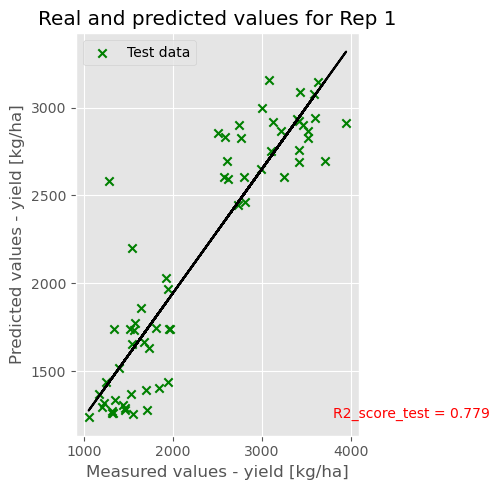

In [8]:
Y_pred = model_for_pruning.predict(X_test)

mae=mean_absolute_error(Y_test,Y_pred)
mse=mean_squared_error(Y_test,Y_pred)
r2=r2_score(Y_test,Y_pred)

print('MAE test: {:.3f}'.format(mae))
print('MSE test: {:.3f}'.format(mse))
print('R^2 test: {:.3f}'.format(r2))

plot_regression(Y_test,Y_pred,directory=results_dir, rep=str(i))

As we can see, a 40% pruning reduced the performance of the model, but it is still in acceptable values.

Now, we need to compress the model to reduce its size.

In [9]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

pruned_file = os.path.join(results_dir, 'pruned.h5')
save_model(model_for_export, pruned_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_file)

Saved pruned Keras model to: /u2/jwt804/SHAP_MSI/results_pruning/pruned.h5


We can reduce the size of the model, applying pruning and quantization tools.

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #quatization
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                      tf.lite.OpsSet.SELECT_TF_OPS]
pruned_tflite_model = converter.convert()

pruned_tflite_file = os.path.join(results_dir, 'pruned_quatized.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned and quantized TFLite model to:', pruned_tflite_file)


INFO:tensorflow:Assets written to: /tmp/tmprwtvkbxy/assets
Saved pruned and quantized TFLite model to: /u2/jwt804/SHAP_MSI/results_pruning/pruned_quatized.tflite
